In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False



import sys,os,pdb,copy,pickle
from importlib import reload
# import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp


import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


In [67]:
import matplotlib.pyplot as plt

# Set default figure size
plt.rcParams['figure.figsize'] = (6, 4)  # width, height in inches

# Set default font sizes
plt.rcParams['font.size'] = 15  # Default font size
plt.rcParams['axes.titlesize'] = 15  # Title font size
plt.rcParams['axes.labelsize'] = 15  # Label font size
plt.rcParams['xtick.labelsize'] = 15  # x-axis tick label font size
plt.rcParams['ytick.labelsize'] = 15  # y-axis tick label font size
plt.rcParams['legend.fontsize'] = 15  # Legend font size
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [2]:

figdir = '/mnt/home/szheng/ceph/place_variability/fig/paper/figure_variability_axis'
figdir_supp = '/mnt/home/szheng/ceph/place_variability/fig/paper/figure_variability_axis/supp'
misc.get_or_create_subdir(figdir)
misc.get_or_create_subdir(figdir_supp)
data_dir = '/mnt/home/szheng/ceph/place_variability/data/paper'
misc.get_or_create_subdir(data_dir)
figdir_supp_shtest=misc.get_or_create_subdir(figdir_supp,f'ex_shtest')

In [3]:
import database
db = database.db

subdb = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)
subdb = subdb.query('ntrials>=20&n_neurons>=50')
to_exclude_sess = ['e16_3m2_211211']
subdb=subdb.loc[~subdb['sess_name'].isin(to_exclude_sess)]


import pf_recombine_central as pfrc
import fr_map_one_session as fmos
import switch_detection_one_session as sdos
import get_all_switch_add_metrics as gasam

import preprocess_one_session as prepos

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [4]:
fn = 'prepped_data_agg.p'
fn_full = os.path.join(data_dir,fn)
prepped_data_agg = pickle.load(open(fn_full,'rb'))

all_fields_recombined_all = prepped_data_agg['all_fields_recombined_all']
pf_params_recombined_all=  prepped_data_agg['pf_params_recombined_all']
fr_map_trial_df_all= prepped_data_agg['fr_map_trial_df_all']
occu_map_all = prepped_data_agg['occu_map_all']
fr_map_all = prepped_data_agg['fr_map_all']

pval_all = prepped_data_agg['pval_all']
X_pwc_all = prepped_data_agg['X_pwc_all']
X_raw_all = prepped_data_agg['X_raw_all']
changes_df_all = prepped_data_agg['changes_df_all']
var_res_all_test = prepped_data_agg['var_res_all']
# corr_all = prepped_data_agg['corr_all']
all_sw_d_all = prepped_data_agg['all_sw_d_all']
all_sw_with_metrics_d_all = prepped_data_agg['all_sw_with_metrics_d_all']
best_n_all_test = prepped_data_agg['best_n_all']
spk_beh_df_all = prepped_data_agg['spk_beh_df_all']

ntrials_per_tt=fr_map_trial_df_all.groupby(level=(0,1,2,3)).apply(lambda x:x.dropna(axis=1,how='all').shape[1])
ntrials_mask = ntrials_per_tt.groupby(level=(0,1,2)).apply(lambda x:(x>=7).all()) 



In [5]:
var_res_all_test['fit_var_ratio_1cp'] = pval_all[1]['exp_var_ratio']
var_res_all_test['fit_var_ratio_div_sh_1cp'] = pval_all[1]['exp_var_ratio'] / pval_all[1]['exp_var_ratio_sh_med']

In [6]:
best_n_all_ = best_n_all_test
import glob
cell_metrics_df_all = {}
for ind,row in subdb.iterrows():
    data_dir_full = row['data_dir_full']
    ani = ind[0]
    sess = row['sess_name']
    
    cell_metrics=glob.glob(os.path.join(data_dir_full,'*cell_metrics.cellinfo.mat'))[0]
    cell_metrics = dpn.loadmat_full(cell_metrics,'cell_metrics')
    
    metrics=['UID','putativeCellType','firingRate','firingRateCV','firingRate_NREMstate','firingRate_REMstate','firingRate_WAKEstate','burstIndex_Mizuseki2012']
    cell_metrics_df = pd.DataFrame({k:cell_metrics[k] for k in metrics})
    cell_metrics_df_all[ani,sess] = cell_metrics_df
cell_metrics_df_all = pd.concat(cell_metrics_df_all,axis=0)

cell_metrics_df_all['UID'] = cell_metrics_df_all['UID'].astype(int)
cell_metrics_df_all = cell_metrics_df_all.reset_index(level=2,drop=True).set_index('UID',append=True)

# field with any switch vs no switch, metrics
task_index=0
cell_with_any_sw_one_task = best_n_all_.loc[(slice(None),slice(None),task_index)].groupby(level=(0,1,3)).apply(lambda x:(x>0).any())
cell_metrics_df_all['has_switch']  = cell_with_any_sw_one_task

ma=cell_metrics_df_all['has_switch'].notna()
cell_metrics_df_all_pc = cell_metrics_df_all.loc[ma]

In [5]:
import variability_axis as va
reload(va)

<module 'variability_axis' from '/mnt/home/szheng/projects/place_variability/code/variability_axis.py'>

In [144]:
per_field_var_metrics=va.get_per_field_var_metrics(X_raw_all,pf_params_recombined_all,all_fields_recombined_all,var_res_all=var_res_all_test,level=(0,1,2,3),pf_params_loc_ind=2)




In [145]:
per_tt_neuron_metrics = va.get_per_neuron_metrics(spk_beh_df_all,fr_map_trial_df_all,fr_map_all,occu_map_all,stab_level=(0,1,2,3,4),si_level=(0,1))

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/mnt/home/szheng/projects/place_variability/code/variability_axis.py:41: PerformanceWarning: indexing past lexsort depth may impact performance.
  cell_cols = fr_map_trial_df_all.loc[k,:].index.get_level_values(2).unique()
/mnt/home/szheng/projects/place_variability/code/variability_axis.py:41: PerformanceWarning: indexing past lexsort depth may impact performance.
  cell_cols = fr_map_trial_df_all.loc[k,:].index.get_level_values(2).unique()
/mnt/home/szheng/projects/place_variability/code/variability_axis.py:41: PerformanceWarning: indexing past lexsort depth may impact performance.
  cell_cols = fr_map_trial_df_all.loc[k,:].index.get_level_values(2).unique()
/mnt/home/szheng/projects/place_variability/code/variability_axis.py:41: PerformanceWarning: indexing past lexsort depth may i

/mnt/home/szheng/projects/place_variability/code/variability_axis.py:41: PerformanceWarning: indexing past lexsort depth may impact performance.
  cell_cols = fr_map_trial_df_all.loc[k,:].index.get_level_values(2).unique()
/mnt/home/szheng/projects/place_variability/code/variability_axis.py:41: PerformanceWarning: indexing past lexsort depth may impact performance.
  cell_cols = fr_map_trial_df_all.loc[k,:].index.get_level_values(2).unique()
/mnt/home/szheng/projects/place_variability/code/variability_axis.py:41: PerformanceWarning: indexing past lexsort depth may impact performance.
  cell_cols = fr_map_trial_df_all.loc[k,:].index.get_level_values(2).unique()
/mnt/home/szheng/projects/place_variability/code/variability_axis.py:41: PerformanceWarning: indexing past lexsort depth may impact performance.
  cell_cols = fr_map_trial_df_all.loc[k,:].index.get_level_values(2).unique()
/mnt/home/szheng/projects/place_variability/code/variability_axis.py:41: PerformanceWarning: indexing past l

In [146]:
per_field_metrics_all = va.assign_per_neuron_property_to_field(per_field_var_metrics,per_tt_neuron_metrics)

In [6]:
savefn_full = os.path.join(data_dir,'per_field_metrics_shtest_with_1cp.p')
# pickle.dump(per_field_metrics_all,open(savefn_full,'wb'))
per_field_metrics_all=pickle.load(open(savefn_full,'rb'))

In [20]:
per_field_metrics_all

frac_trial_active  fr_cv_beh   loc_std  \
e13_26m1 e13_26m1_210913 0 0.0  3  0           0.696970   0.705983  4.374080   
                                27 0           1.000000   0.227746  6.913563   
                                29 0           0.787879   0.701315  1.986221   
                                   1           1.000000   0.201301  3.270333   
                                   2           1.000000   0.388584  2.973685   
...                                                 ...        ...       ...   
e14_2m3  e14_2m3_201118  0 both 30 0           1.000000   0.432693  3.326442   
                                32 0           0.958333   0.516519  6.448795   
                                38 0           0.833333   0.713964  1.966661   
                                47 0           0.958333   0.610375  2.738613   
                                53 0           0.708333   0.795243  2.527745   

                                     field_width    tot_var       mean  \
e13_26m1 e13_26m1_210913 0 0.0  3  0          16   4.291338   2.979778   
                                27 0          30  54.997992  33.067719   
                                29 0           7  17.511026   6.059328   
                                   1          18  27.155813  26.288630   
                                   2          16  44.745505  17.481232   
...                                          ...        ...        ...   
e14_2m3  e14_2m3_201118  0 both 30 0          17  13.526576   8.682727   
                                32 0          21  35.811976  11.835044   
                                38 0           7  42.932386   9.374712   
                                47 0           6  14.870425   6.453665   
                                53 0           6   7.496653   3.517027   

                                        fit_var  resid2_mean  fit_var_ratio  \
e13_26m1 e13_26m1_210913 0 0.0  3  0   2.108064     2.183274       0.491237   
                                27 0   0.000000    54.997992       0.000000   
                                29 0  10.935146     6.575879       0.624472   
                                   1   0.000000    27.155813       0.000000   
                                   2   0.000000    44.745505       0.000000   
...                                         ...          ...            ...   
e14_2m3  e14_2m3_201118  0 both 30 0   0.000000    13.526576       0.000000   
                                32 0   0.000000    35.811976       0.000000   
                                38 0   0.000000    42.932386       0.000000   
                                47 0   0.000000    14.870425       0.000000   
                                53 0   0.000000     7.496653       0.000000   

                                      resid2_mean_ratio  tot_var_norm  \
e13_26m1 e13_26m1_210913 0 0.0  3  0           0.508763      1.440154   
                                27 0           1.000000      1.663193   
                                29 0           0.375528      2.889929   
                                   1           1.000000      1.032987   
                                   2           1.000000      2.559631   
...                                                 ...           ...   
e14_2m3  e14_2m3_201118  0 both 30 0           1.000000      1.557872   
                                32 0           1.000000      3.025927   
                                38 0           1.000000      4.579595   
                                47 0           1.000000      2.304183   
                                53 0           1.000000      2.131531   

                                      fit_var_norm  resid2_mean_norm  \
e13_26m1 e13_26m1_210913 0 0.0  3  0      0.707457          0.732697   
                                27 0      0.000000          1.663193   
                                29 0      1.804680          1.085249   
                                   1      0.000000          1.032987   
  

# selecting examples

In [68]:
import matplotlib.patches as patches

/tmp/ipykernel_71921/344623233.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_71921/344623233.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_71921/344623233.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_71921/344623233.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_71921/344623233.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_

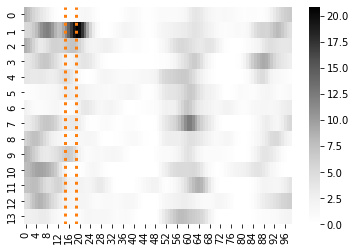

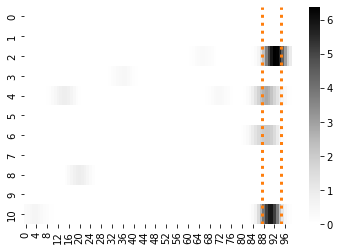

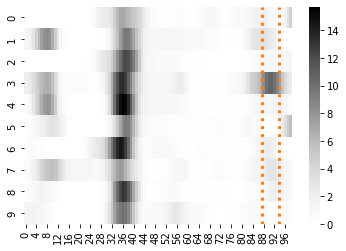

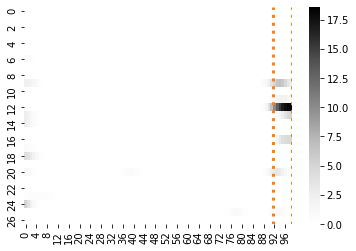

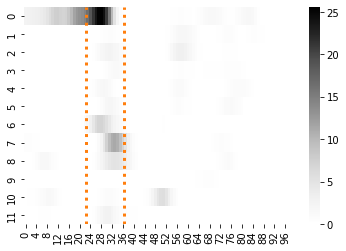

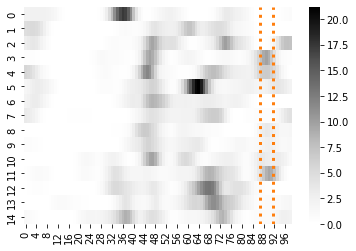

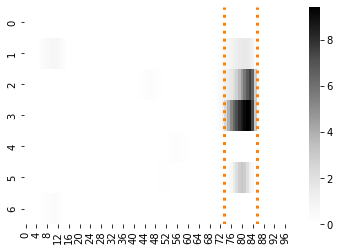

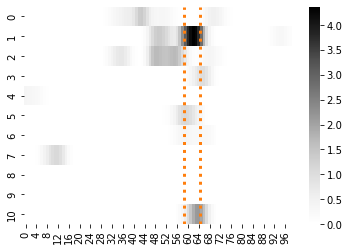

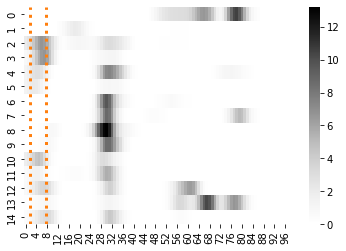

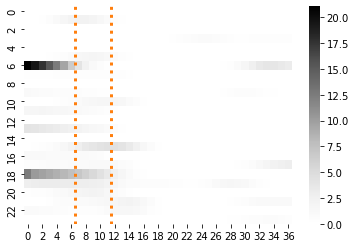

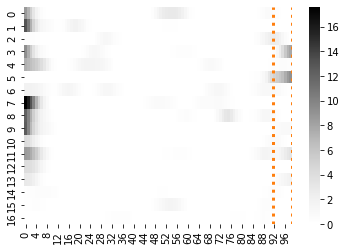

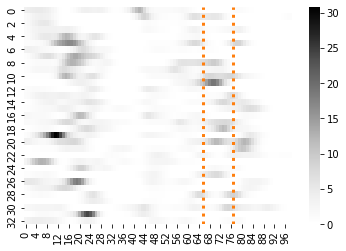

In [24]:
# # ma=(per_field_metrics_all['fit_var_ratio_1cp'] < 0.3)&(per_field_metrics_all['fit_var_ratio_div_sh_1cp'] > 3)
# # ma=(per_field_metrics_all['fit_var_ratio_1cp'] > 0.6)&(per_field_metrics_all['fit_var_ratio_div_sh_1cp'] < 2.)
# ma=(per_field_metrics_all['fit_var_ratio_1cp'] < 0.3)&(per_field_metrics_all['fr_cv_beh'] > 1.)
# inds=per_field_metrics_all.loc[ma].sample(12).index
# for ind in inds:
#     fig,ax=None,None
#     ani,sess,ti,tt,uid,field_id = ind
#     if tt=='both':
#         tt_rm=0
#     else:
#         tt_rm=tt
#     fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
#     field_bound = all_fields_recombined_all.loc[(ani,sess,ti,tt,uid,field_id),('start','end')]
#     ph.ratemap_one_raw(fr_map_trial_one,field_bound=field_bound,fig=fig,ax=ax,line_kws={},title=None,heatmap_kws={})

In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler,QuantileTransformer

In [8]:
# switchy_key = "fit_var_ratio_div_sh_1cp"
switchy_key = "fit_var_ratio_1cp"
pf_key = "lap_correlation"
var_key = "fr_cv_beh"

# feat_cols = ['lap_correlation','fr_cv_beh','fit_var_ratio_div_sh_1cp']
feat_cols = [pf_key,var_key,switchy_key]
# feat_cols = ['lap_correlation','resid2_mean_norm','fit_var_ratio_div_sh_1cp']



In [9]:
per_field_metrics_all_sub = per_field_metrics_all.loc[(slice(None),slice(None),[0])]
data=per_field_metrics_all_sub.loc[:,feat_cols]
data_norm = QuantileTransformer().fit_transform(data)
data_norm = pd.DataFrame(data_norm,index=data.index,columns=data.columns)


In [19]:
ma_l.sum(axis=0)

lap_correlation_low; fr_cv_beh_low        6
lap_correlation_low; fr_cv_beh_mid       23
lap_correlation_low; fr_cv_beh_high     189
lap_correlation_mid; fr_cv_beh_low       28
lap_correlation_mid; fr_cv_beh_mid       50
lap_correlation_mid; fr_cv_beh_high      51
lap_correlation_high; fr_cv_beh_low      37
lap_correlation_high; fr_cv_beh_mid      45
lap_correlation_high; fr_cv_beh_high     53
dtype: int64

In [17]:
import itertools
val_interval_categories={'low':(0,0.2),'mid':(0.4,0.6),'high':(0.8,1.)}
# val_interval_categories={'low':(0,0.3),'high':(0.7,1.)}
feat_cols_to_combo = [pf_key,var_key]
n_feat_cols = len(feat_cols_to_combo)
category_combo_l = list(itertools.product(val_interval_categories,repeat=n_feat_cols))
ma_l = {}
for catco in category_combo_l:
    ma = np.ones(data_norm.shape[0],dtype=bool)
    ma_name = []
    for ii,cat in enumerate(catco):
        val_interval = val_interval_categories[cat]
        feat = feat_cols_to_combo[ii]
        ma&=(data_norm[feat]>=val_interval[0])&(data_norm[feat]<=val_interval[1])
        ma_name.append(f'{feat}_{cat}')
    ma_name = '; '.join(ma_name)
    ma_l[ma_name]=ma


ma_l = pd.concat(ma_l,axis=1)
# switchy_thresh = 0.95
switchy_thresh = 0.9
switchy_ma = data_norm[switchy_key]>switchy_thresh
ma_l = np.logical_and(ma_l,switchy_ma.values[:,None])
        


In [43]:
def transform_title(combo_name):
    trans_d = {'lap':"Lap-lap Corr.",' fr':"CV (Firing rate)"}
    title = ""
    title=[]
    for k in combo_name.split(';'):
        k_l=k.split('_')
        title.append(trans_d[k_l[0]]+': '+k_l[-1].upper())
    title="\n".join(title)
    return title

In [89]:
# # switchy_thresh = 0.95
# # data_sub = data_norm.loc[data_norm[switchy_key] > switchy_thresh]
# # ma_l = [{switchy_key:(switchy_thresh,np.inf),pf_key:(0,0.1)},
# #         {switchy_key:(switchy_thresh,np.inf),pf_key:(0.4,0.6)},
# #         {switchy_key:(switchy_thresh,np.inf),pf_key:(0.9,1.)}]
# # for ma_ in ma_l:
# #     ma = np.ones(data_norm.shape[0],dtype=bool)
# #     for k,val in ma_.items():
# #         ma &= (data_norm[k]>=val[0])&(data_norm[k]<=val[1])
# #     toplot_inds=data_norm.loc[ma].sample(1).index
# nsample = 8
# for combo_name,ma in ma_l.T.iterrows():

#     data_sub = data_norm.loc[ma].loc[(slice(None),more_trials_sess),:]
#     try:
#         if data_sub.shape[0]>nsample:
#             toplot_inds=data_sub.sample(8).index
#         else:
#             toplot_inds = data_sub.index
#     except Exception as e:
#         toplot_inds = None
#         print(e)
#     if toplot_inds is not None:
#         nplots=len(toplot_inds)
#     #     fig,axs=ph.subplots_wrapper(nplots,squeeze=False)

#         for ii,jj in enumerate(toplot_inds):
# #             fig,axs = plt.subplots(1,2,sharey=True)
#             fig,axs = plt.subplots(1,2)
#             ani,sess,ti,tt,uid,field_id=jj
#             if tt=='both':
#                 tt_rm=0
#             else:
#                 tt_rm=tt

#             index_within_to_trial_index_df = dpp.index_within_to_trial_index(spk_beh_df_all.loc[(ani,sess),:])
#             index_within_to_trial_index_df
#             ncpt=1
#             ax=axs[0]
#             signal = X_raw_all.loc[ani,sess,ti,tt,uid,field_id]
#             signal=signal.loc[index_within_to_trial_index_df.loc[ti,tt_rm]]
#             signal=signal.dropna().values
#             fig,ax,pwc,change_trial_within=cpa.predict_from_cpts_wrapper_plot(signal,ncpt,cost='l2',min_size=2,fig=fig,ax=ax)

            
#     #         ax=axs.ravel()[ii]
#             ax=axs[1]
            
#             fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
#             field_bound = all_fields_recombined_all.loc[(ani,sess,ti,tt,uid,field_id),('start','end')]
#             ph.ratemap_one_raw(fr_map_trial_one,trial=change_trial_within,field_bound=field_bound,fig=fig,ax=ax,line_kws={},title=None,heatmap_kws={})
#     #         ax.set_title(f'{tt}, {uid}, {field_id}')
#             title = transform_title(combo_name)
#             ax.set_title(title)
#             ax.set(xticks=[],yticks=[])

#             plt.tight_layout()
#             fn_full = os.path.join(figdir_supp_shtest,f'{combo_name}_examples_{ii}.svg')
#             fig.savefig(fn_full,bbox_inches='tight')
#             plt.close(fig)


/tmp/ipykernel_874995/1446098965.py:14: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  data_sub = data_norm.loc[ma].loc[(slice(None),more_trials_sess),:]
/tmp/ipykernel_874995/1446098965.py:36: PerformanceWarning: indexing past lexsort depth may impact performance.
  index_within_to_trial_index_df = dpp.index_within_to_trial_index(spk_beh_df_all.loc[(ani,sess),:])
/tmp/ipykernel_874995/1446098965.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_874995/1446098965.py:14: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will ch

/tmp/ipykernel_874995/1446098965.py:36: PerformanceWarning: indexing past lexsort depth may impact performance.
  index_within_to_trial_index_df = dpp.index_within_to_trial_index(spk_beh_df_all.loc[(ani,sess),:])
/tmp/ipykernel_874995/1446098965.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_874995/1446098965.py:36: PerformanceWarning: indexing past lexsort depth may impact performance.
  index_within_to_trial_index_df = dpp.index_within_to_trial_index(spk_beh_df_all.loc[(ani,sess),:])
/tmp/ipykernel_874995/1446098965.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_874995/1446098965.py:36: PerformanceWarning: indexing past lexsort depth may impact performance.
  index_within_to_trial_index_df = dpp.index_within_to_trial_ind

/tmp/ipykernel_874995/1446098965.py:36: PerformanceWarning: indexing past lexsort depth may impact performance.
  index_within_to_trial_index_df = dpp.index_within_to_trial_index(spk_beh_df_all.loc[(ani,sess),:])
/tmp/ipykernel_874995/1446098965.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_874995/1446098965.py:14: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  data_sub = data_norm.loc[ma].loc[(slice(None),more_trials_sess),:]
/tmp/ipykernel_874995/1446098965.py:36: PerformanceWarning: indexing past lexsort depth may impact performance.
  index_within_to_trial_index_df = dpp.ind

/tmp/ipykernel_874995/1446098965.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_874995/1446098965.py:36: PerformanceWarning: indexing past lexsort depth may impact performance.
  index_within_to_trial_index_df = dpp.index_within_to_trial_index(spk_beh_df_all.loc[(ani,sess),:])
/tmp/ipykernel_874995/1446098965.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_874995/1446098965.py:36: PerformanceWarning: indexing past lexsort depth may impact performance.
  index_within_to_trial_index_df = dpp.index_within_to_trial_index(spk_beh_df_all.loc[(ani,sess),:])
/tmp/ipykernel_874995/1446098965.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,ui

In [100]:
def panel_scatter(x='fit_var_ratio_1cp',y='lap_correlation',fig=None,ax=None):
    trans_d = {'fit_var_ratio_1cp':"Explained Var. Ratio ('switchy')",
               'lap_correlation':"Lap-lap correlation ('shifty')",
               'fr_cv_beh':"CV Firing rate ('noisy')",
              }
    if ax is None:
        fig,ax=plt.subplots()
    ax=sns.histplot(data=data,x=x,y=y,ax=ax,cmap='Greys')
    xlabel = trans_d[x]
    ylabel=trans_d[y]
    ax.set(xlabel=xlabel,ylabel=ylabel)
    return fig,ax
    

In [81]:
# def panel_scatter_1(fig=None,ax=None):
#     if ax is None:
#         fig,ax=plt.subplots()
# #     ax=sns.histplot(data=data,x='fit_var_ratio_div_sh_1cp',y='lap_correlation',ax=ax)
#     ax=sns.histplot(data=data,x='fit_var_ratio_1cp',y='lap_correlation',ax=ax,cmap='Greys')
#     ax.set(xlabel="Switching index",ylabel="Lap-lap correlation")
#     return fig,ax

# def panel_scatter_2(fig=None,ax=None):
#     if ax is None:
#         fig,ax=plt.subplots()
# #     ax=sns.histplot(data=data,x='fit_var_ratio_div_sh_1cp',y='fr_cv_beh',ax=ax)
#     ax=sns.histplot(data=data,x='fit_var_ratio_1cp',y='fr_cv_beh',ax=ax)
#     ax.set(xlabel="Switching index",ylabel="CV (Firing rate)")
#     return fig,ax

# def panel_scatter_3(fig=None,ax=None):
#     if ax is None:
#         fig,ax=plt.subplots()
#     ax=sns.histplot(data=data,x='lap_correlation',y='fr_cv_beh',ax=ax)
#     ax.set(xlabel="Lap-lap correlation",ylabel="CV (Firing rate)")
#     return fig,ax





/tmp/ipykernel_71921/2649485398.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  subdata=data_norm.loc[(ani,sess),:]
/tmp/ipykernel_71921/2649485398.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  subdata_tolabel = data.loc[(ani,sess),:] # pre normalization
/tmp/ipykernel_71921/2649485398.py:41: PerformanceWarning: indexing past lexsort depth may impact performance.
  index_within_to_trial_index_df = dpp.index_within_to_trial_index(spk_beh_df_all.loc[(ani,sess),:])
/tmp/ipykernel_71921/2649485398.py:55: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_71921/2649485398.py:41: PerformanceWarning: indexing past lexsort depth may impact performance.
  index_within_to_trial_index_df = dpp.index_within_to_trial_index(spk_beh_df_all.loc[(ani,sess),:])
/tmp/ipykernel_71921/2649485398.py:55: PerformanceWarning

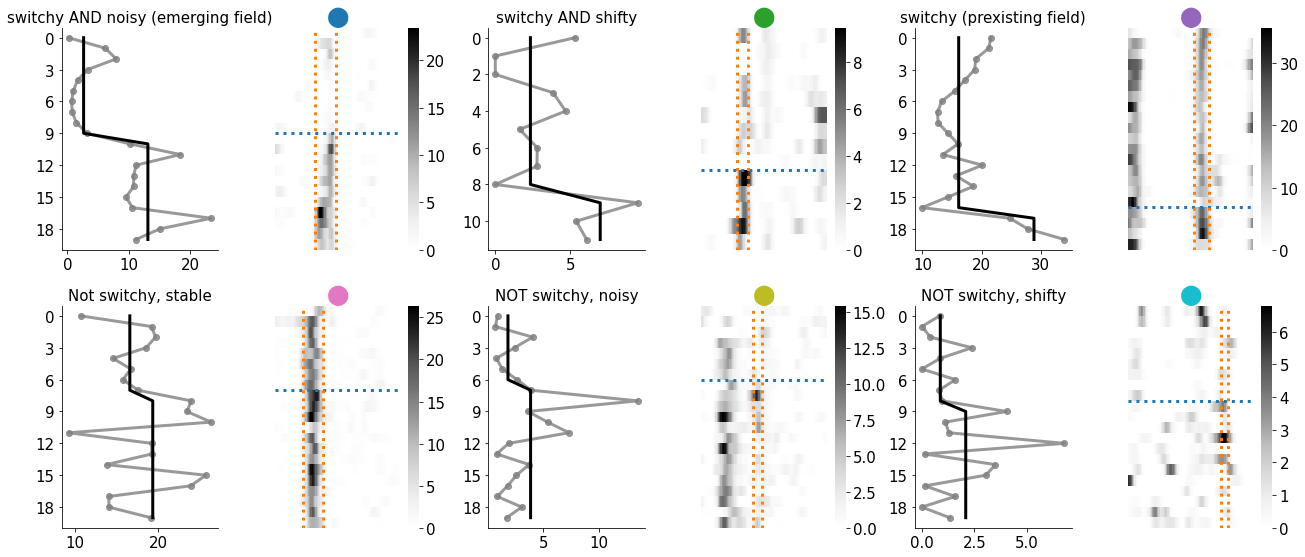

In [123]:
def plot_examples(fig=None,axs_all=None):
    ani='e15_13f1'
    sess='e15_13f1_220117'
    subdata=data_norm.loc[(ani,sess),:]
    subdata_tolabel = data.loc[(ani,sess),:] # pre normalization
    ma_d = {
        'switchy AND noisy (emerging field)':(subdata[switchy_key]>0.9)&(subdata[pf_key]>0.)&(subdata[var_key]>0.7)&((subdata[var_key]<0.8)),
        'switchy AND shifty':(subdata[switchy_key]>0.8)&(subdata[pf_key]<0.3)&(subdata[pf_key]>0.2)&(subdata[var_key]<0.8)&(subdata[var_key]>0.4),
        'switchy (prexisting field)':(subdata[switchy_key]>0.9)&(subdata[pf_key]>0.8)&(subdata[var_key]<0.3),
        'Not switchy, stable':(subdata[switchy_key]<0.2)&(subdata[pf_key]>0.8)&(subdata[var_key]<0.1),
        'NOT switchy, noisy':(subdata[switchy_key]<0.2)&(subdata[pf_key]>0.5)&(subdata[var_key]>0.8),
        'NOT switchy, shifty':(subdata[switchy_key]<0.2)&(subdata[pf_key]<0.2)&(subdata[var_key]>0.5),
    }

    iloc_l = [0,0,0,0,0,0]
    colors = plt.cm.tab10(np.linspace(0, 1, 6))
    coord_l = []

    fig,axs_all = plt.subplots(2,6,figsize=(3*6,2*4))


    for ll,(combo_name,ma) in enumerate(ma_d.items()):

        data_sub = subdata.loc[ma]
        jj=data_sub.index[iloc_l[ll]]



    #     fig,axs=ph.subplots_wrapper(nplots,squeeze=False)

    #         for ii,jj in enumerate(toplot_inds):
    #             fig,axs = plt.subplots(1,2,sharey=True)
    #     fig,axs = plt.subplots(1,2)
        axs = axs_all.ravel()[ll*2:(ll+1)*2]
        ti,tt,uid,field_id=jj
        if tt=='both':
            tt_rm=0
        else:
            tt_rm=tt

        index_within_to_trial_index_df = dpp.index_within_to_trial_index(spk_beh_df_all.loc[(ani,sess),:])
        index_within_to_trial_index_df
        ncpt=1
        ax=axs[0]
        signal = X_raw_all.loc[ani,sess,ti,tt,uid,field_id]
        signal=signal.loc[index_within_to_trial_index_df.loc[ti,tt_rm]]
        signal=signal.dropna().values
        fig,ax,pwc,change_trial_within=cpa.predict_from_cpts_wrapper_plot(signal,ncpt,cost='l2',min_size=2,fig=fig,ax=ax,dolabel=False)
        title = combo_name
        ax.set_title(title)

    #         ax=axs.ravel()[ii]
        ax=axs[1]

        fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
        field_bound = all_fields_recombined_all.loc[(ani,sess,ti,tt,uid,field_id),('start','end')]
        ph.ratemap_one_raw(fr_map_trial_one,trial=change_trial_within,field_bound=field_bound,fig=fig,ax=ax,line_kws={},title=None,heatmap_kws={})
    #         ax.set_title(f'{tt}, {uid}, {field_id}')
    #     title = transform_title(combo_name)


        ax.set(xticks=[],yticks=[])
        color = colors[ll]
    #     circle = patches.Circle((0.5, 0.9), radius=0.1, transform=ax.transAxes, color=color, ec="none")
    #     ax.add_patch(circle)
        ax.set_title('⬤', color=color, fontsize=20)

        

        coord = subdata_tolabel.loc[jj]
        coord_l.append(coord)
    plt.tight_layout()
    return fig,axs_all,coord_l, colors

fig,axs_all,coord_l,colors = plot_examples(fig=None,axs_all=None)
fig.savefig(os.path.join(figdir,f'examples.svg'),bbox_inches='tight')

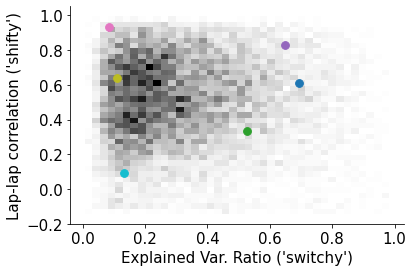

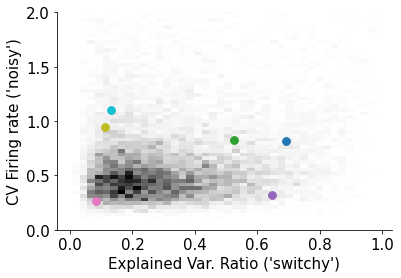

In [124]:
x1='fit_var_ratio_1cp'
y1='lap_correlation'
fig1,ax1=panel_scatter(x=x1,y=y1)
x2=x1
y2='fr_cv_beh'
fig2,ax2=panel_scatter(x=x2,y=y2)
for i in range(len(coord_l)):
    ax1.scatter(coord_l[i][x1],coord_l[i][y1],color=colors[i],s=60.)
    ax2.scatter(coord_l[i][x2],coord_l[i][y2],color=colors[i],s=60.)
ax2.set_ylim([0,2])

fig1.savefig(os.path.join(figdir,f'{y1}_vs_{x1}.svg'),bbox_inches='tight')
fig2.savefig(os.path.join(figdir,f'{y2}_vs_{x2}.svg'),bbox_inches='tight')

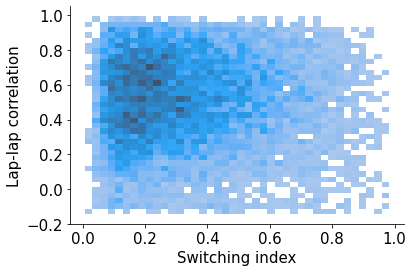

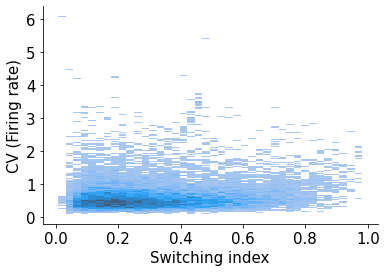

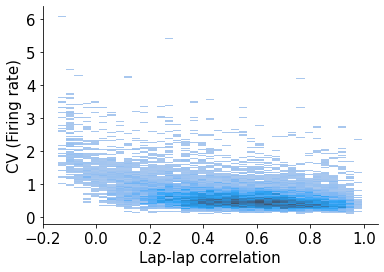

In [80]:
# fig,ax=panel_scatter_1()
# fig.savefig(os.path.join(figdir,'lap_corr_vs_sw_ind.svg'),bbox_inches='tight')
# fig,_=panel_scatter_2()
# fig.savefig(os.path.join(figdir,'cvfr_vs_sw_ind.svg'),bbox_inches='tight')
# fig,_=panel_scatter_3()
# fig.savefig(os.path.join(figdir,'lap_corr_vs_cvfr.svg'),bbox_inches='tight')

In [148]:
per_field_metrics_all

frac_trial_active  fr_cv_beh   loc_std  \
e13_26m1 e13_26m1_210913 0 0.0  3  0           0.696970   0.705983  4.374080   
                                27 0           1.000000   0.227746  6.913563   
                                29 0           0.787879   0.701315  1.986221   
                                   1           1.000000   0.201301  3.270333   
                                   2           1.000000   0.388584  2.973685   
...                                                 ...        ...       ...   
e14_2m3  e14_2m3_201118  0 both 30 0           1.000000   0.432693  3.326442   
                                32 0           0.958333   0.516519  6.448795   
                                38 0           0.833333   0.713964  1.966661   
                                47 0           0.958333   0.610375  2.738613   
                                53 0           0.708333   0.795243  2.527745   

                                     field_width    tot_var       mean  \
e13_26m1 e13_26m1_210913 0 0.0  3  0          16   4.291338   2.979778   
                                27 0          30  54.997992  33.067719   
                                29 0           7  17.511026   6.059328   
                                   1          18  27.155813  26.288630   
                                   2          16  44.745505  17.481232   
...                                          ...        ...        ...   
e14_2m3  e14_2m3_201118  0 both 30 0          17  13.526576   8.682727   
                                32 0          21  35.811976  11.835044   
                                38 0           7  42.932386   9.374712   
                                47 0           6  14.870425   6.453665   
                                53 0           6   7.496653   3.517027   

                                        fit_var  resid2_mean  fit_var_ratio  \
e13_26m1 e13_26m1_210913 0 0.0  3  0   2.108064     2.183274       0.491237   
                                27 0   0.000000    54.997992       0.000000   
                                29 0  10.935146     6.575879       0.624472   
                                   1   0.000000    27.155813       0.000000   
                                   2   0.000000    44.745505       0.000000   
...                                         ...          ...            ...   
e14_2m3  e14_2m3_201118  0 both 30 0   0.000000    13.526576       0.000000   
                                32 0   0.000000    35.811976       0.000000   
                                38 0   0.000000    42.932386       0.000000   
                                47 0   0.000000    14.870425       0.000000   
                                53 0   0.000000     7.496653       0.000000   

                                      resid2_mean_ratio  tot_var_norm  \
e13_26m1 e13_26m1_210913 0 0.0  3  0           0.508763      1.440154   
                                27 0           1.000000      1.663193   
                                29 0           0.375528      2.889929   
                                   1           1.000000      1.032987   
                                   2           1.000000      2.559631   
...                                                 ...           ...   
e14_2m3  e14_2m3_201118  0 both 30 0           1.000000      1.557872   
                                32 0           1.000000      3.025927   
                                38 0           1.000000      4.579595   
                                47 0           1.000000      2.304183   
                                53 0           1.000000      2.131531   

                                      fit_var_norm  resid2_mean_norm  \
e13_26m1 e13_26m1_210913 0 0.0  3  0      0.707457          0.732697   
                                27 0      0.000000          1.663193   
                                29 0      1.804680          1.085249   
                                   1      0.000000          1.032987   
  

# quickly test if using 1 cp, still can select nice examples, and old new environment relationship more strong

In [24]:
pval_all.loc[:,(slice(None),'exp_var_ratio')].corr()

,,1,2,3,4,5
,,exp_var_ratio,exp_var_ratio,exp_var_ratio,exp_var_ratio,exp_var_ratio
1,exp_var_ratio,1.000000,0.818566,0.777781,0.761437,0.751956
2,exp_var_ratio,0.818566,1.000000,0.957117,0.927050,0.902214
3,exp_var_ratio,0.777781,0.957117,1.000000,0.975395,0.956472
4,exp_var_ratio,0.761437,0.927050,0.975395,1.000000,0.987867
5,exp_var_ratio,0.751956,0.902214,0.956472,0.987867,1.000000


In [68]:
pval_one_cp = pval_all[1]
pval_one_cp_per_cell = pval_one_cp.groupby(sort=False,level=(0,1,2,4)).mean()

In [69]:
pval_one_cp_per_cell['exp_var_ratio_div_sh']=pval_one_cp_per_cell['exp_var_ratio']/pval_one_cp_per_cell['exp_var_ratio_sh_med']




<Axes: xlabel='0', ylabel='1'>

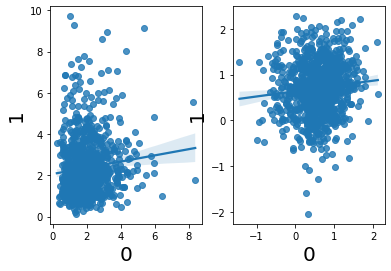

In [79]:
toplot=pval_one_cp_per_cell['exp_var_ratio_div_sh'].unstack(level=2).dropna(axis=0)
fig,axs=plt.subplots(1,2)
ax=axs[0]
sns.regplot(x=toplot[0],y=toplot[1],ax=ax)
ax=axs[1]
sns.regplot(x=np.log(toplot[0]),y=np.log(toplot[1]),ax=ax)

In [125]:
pval_one_cp_per_cell_fam = pval_one_cp_per_cell.loc[(slice(None),slice(None),0),:].droplevel(2)

In [127]:
inds=pval_one_cp_per_cell_fam.index

In [141]:

pd.concat([pval_one_cp_per_cell_fam['exp_var_ratio_div_sh'],cell_metrics_df_all_pc['firingRate']],axis=1)



exp_var_ratio_div_sh  firingRate
e13_26m1 e13_26m1_210913 3               4.207831    0.043923
                         27              1.458443    9.412340
                         29              2.142163    2.406657
                         30              1.474854    2.335488
                         31              3.914783    2.276269
...                                           ...         ...
e14_2m3  e14_2m3_201118  47              1.441041    1.695707
                         48              1.600478    9.430529
                         50              2.615775    0.744755
                         53              1.489579    2.381342
                         40              1.803309    0.287176

[4486 rows x 2 columns]

                           UID
e13_26m1  e13_26m1_210913  3      0.043923
                           27     9.412340
                           29     2.406657
                           30     2.335488
                           31     2.276269
                                    ...   
e14_2m3   e14_2m3_201118   46     1.365643
                           47     1.695707
                           48     9.430529
                           50     0.744755
                           53     2.381342
Name: firingRate, Length: 4486, dtype: float64

In [80]:
scipy.stats.spearmanr(toplot)

SignificanceResult(statistic=0.11029941357948514, pvalue=0.0006559144759356912)